# MI2 - ES04: Kernel Principal Component Analysis
## The chantastic 4: Elisabeth Kress, Paola Suárez, Jianmeng Wu and Esra Zihni

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Kernel PCA: Toy data set

### 1.a)  Create a toy data set

In [29]:
sd = 0.1
mus = np.array([[-0.5, -0.2], [0, 0.6], [0.5, 0]])
x = []
for i, mu in enumerate(mus):
    x.append(np.random.normal(mu, sd, (30,2)))
x = np.vstack(x)

In [30]:
mus.shape

(3, 2)

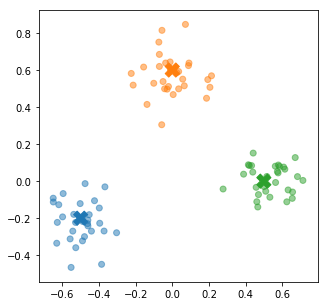

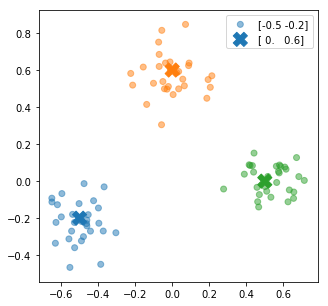

In [50]:
c = np.arange(90) // 30
colors = np.array(['C0', 'C1', 'C2'])
plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], marker='o', c=colors[c], alpha=0.5)
plt.scatter(mus[:,0], mus[:,1], marker='X', s=200, c=colors)
#plt.legend([mus[0,:], mus[1,:], mus[2,:]])
plt.axis('equal')
plt.show()

### 1.b) Apply a Kernel PCA

In [24]:
c

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### 1.c) Visualize the first 8 PCs

### 1.d) Discussion